In [6]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tqdm import tqdm

# Print versions (helpful for reproducibility)
print("Python:", os.sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("TensorFlow:", tf.__version__)


Python: 3.12.4
NumPy: 1.26.4
Pandas: 2.2.3
scikit-learn: 1.4.2
TensorFlow: 2.18.0


In [8]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: mixed precision for faster training on supported GPUs (you can comment out if unsure)
# from tensorflow.keras import mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)
# NOTE: if you enable mixed_precision, ensure output layer dtype is float32 or cast before metrics/loss.


In [18]:
csv_path = r'C:\Users\Yashwardhan Shinde\PBL Project\Chronic_kidney_diesease_analysis\kidneyData_fixed.csv'
df = pd.read_csv(csv_path)
print("Total samples:", len(df))
print("Labels:", df['diag'].value_counts())
df.head()

Total samples: 12446
Labels: diag
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64


,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),C:\Users\Yashwardhan Shinde\PBL Project\Chroni...,Tumor,3,Tumor
1,1,Tumor- (83),C:\Users\Yashwardhan Shinde\PBL Project\Chroni...,Tumor,3,Tumor
2,2,Tumor- (580),C:\Users\Yashwardhan Shinde\PBL Project\Chroni...,Tumor,3,Tumor
3,3,Tumor- (1701),C:\Users\Yashwardhan Shinde\PBL Project\Chroni...,Tumor,3,Tumor
4,4,Tumor- (1220),C:\Users\Yashwardhan Shinde\PBL Project\Chroni...,Tumor,3,Tumor


In [20]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['diag'], random_state=SEED)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print("Train:", len(train_df), "Test:", len(test_df))


Train: 9956 Test: 2490


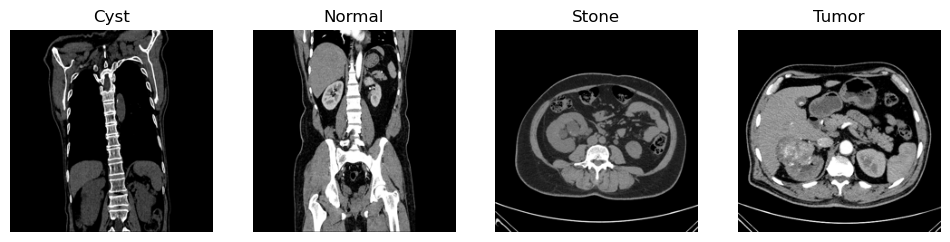

In [22]:
# show a few images from each class
labels = sorted(df['diag'].unique())
plt.figure(figsize=(12, 6))
i = 1
for lab in labels:
    sample = df[df['diag']==lab].sample(1, random_state=SEED).iloc[0]
    img = Image.open(sample['path']).resize((224,224))
    plt.subplot(1, len(labels), i)
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    i += 1
plt.show()


In [24]:
IMAGE_SIZE = 128  # set to 128 or 224 depending on model choice

def augment_image(image_np):
    """image_np: uint8 numpy array HxWxC"""
    img = Image.fromarray(np.uint8(image_np))
    img = ImageEnhance.Brightness(img).enhance(random.uniform(0.85, 1.15))
    img = ImageEnhance.Contrast(img).enhance(random.uniform(0.85, 1.15))
    # add further augment ops if needed: rotate, flip, shift (use tf.image or albumentations for more)
    arr = np.array(img).astype('float32') / 255.0
    return arr

def load_and_preprocess(path):
    img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    arr = np.array(img)
    arr = augment_image(arr)
    return arr

# Encoder
labels_list = sorted(df['diag'].unique())
label_to_idx = {l:i for i,l in enumerate(labels_list)}
def encode_label(labels):
    return np.array([label_to_idx[l] for l in labels])


In [26]:
def py_datagen(df_in, batch_size=16, shuffle_data=True, augment=True):
    paths = df_in['path'].values
    labels = df_in['diag'].values
    idxs = np.arange(len(paths))
    while True:
        if shuffle_data:
            np.random.shuffle(idxs)
        for i in range(0, len(paths), batch_size):
            batch_idx = idxs[i:i+batch_size]
            batch_paths = paths[batch_idx]
            batch_labels = labels[batch_idx]
            images = []
            for p in batch_paths:
                images.append(load_and_preprocess(p))
            images = np.array(images)
            labels_enc = encode_label(batch_labels)
            yield images, labels_enc


In [28]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_kidney_model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False)
]


In [30]:
num_classes = len(labels_list)

base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
# optionally unfreeze some of the last conv layers:
# base_model.layers[-2].trainable = True
# base_model.layers[-3].trainable = True

model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 1,049,220 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [32]:
batch_size = 20
train_steps = int(np.ceil(len(train_df) / batch_size))
val_images = np.array([load_and_preprocess(p) for p in test_df['path'].iloc[:200].values])  # small val subset (or use all)
val_labels = encode_label(test_df['diag'].iloc[:200].values)

history = model.fit(
    py_datagen(train_df, batch_size=batch_size, shuffle_data=True),
    epochs=10,
    steps_per_epoch=train_steps,
    validation_data=(val_images, val_labels),
    callbacks=callbacks
)


Epoch 1/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 500s 998ms/step - loss: 1.0187 - sparse_categorical_accuracy: 0.5878 - val_loss: 0.3601 - val_sparse_categorical_accuracy: 0.9150 - learning_rate: 1.0000e-04
Epoch 2/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 493s 991ms/step - loss: 0.3993 - sparse_categorical_accuracy: 0.8629 - val_loss: 0.2165 - val_sparse_categorical_accuracy: 0.9450 - learning_rate: 1.0000e-04
Epoch 3/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 494s 992ms/step - loss: 0.2367 - sparse_categorical_accuracy: 0.9288 - val_loss: 0.1199 - val_sparse_categorical_accuracy: 0.9800 - learning_rate: 1.0000e-04
Epoch 4/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 497s 999ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.0903 - val_sparse_categorical_accuracy: 0.9800 - learning_rate: 1.0000e-04
Epoch 5/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 497s 998ms/step - loss: 0.1313 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.0584 - val_sparse_categorical_accuracy: 0.9950 - learning_rate: 1.0000e-04
Epoch 6/10

78/78 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step
              precision    recall  f1-score   support

        Cyst       0.99      1.00      1.00       742
      Normal       1.00      1.00      1.00      1016
       Stone       1.00      0.99      0.99       275
       Tumor       1.00      1.00      1.00       457

    accuracy                           1.00      2490
   macro avg       1.00      1.00      1.00      2490
weighted avg       1.00      1.00      1.00      2490



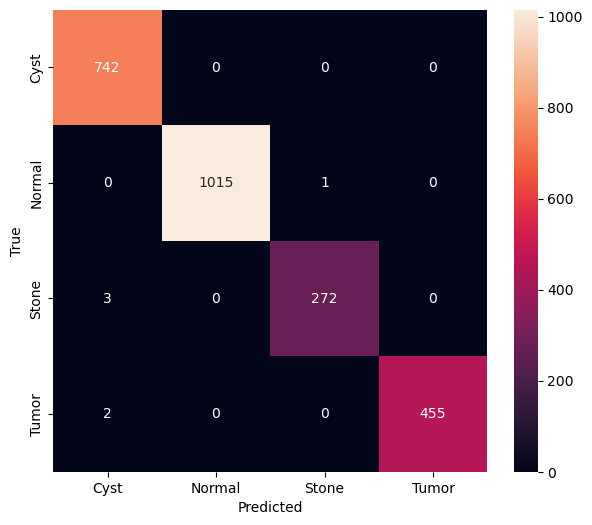

In [34]:
# Load all test images and evaluate
test_images = np.array([load_and_preprocess(p) for p in test_df['path'].values])
test_labels = encode_label(test_df['diag'].values)

preds = model.predict(test_images)
pred_classes = np.argmax(preds, axis=1)

print(classification_report(test_labels, pred_classes, target_names=labels_list))
cm = confusion_matrix(test_labels, pred_classes)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_list, yticklabels=labels_list)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


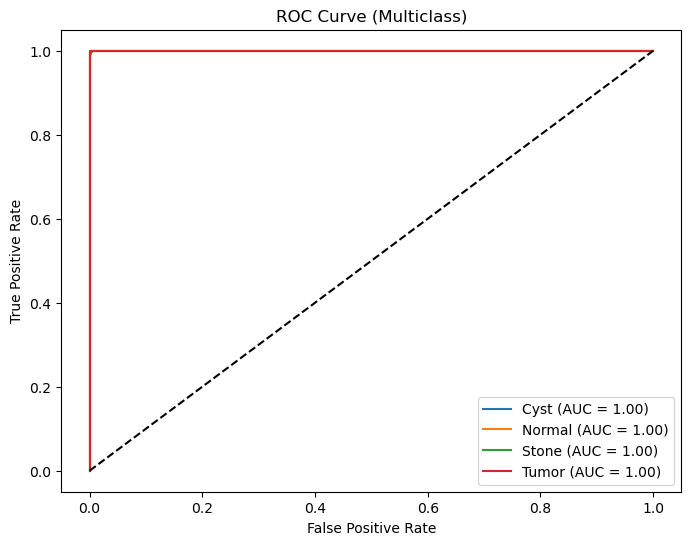

In [36]:
from sklearn.preprocessing import label_binarize

# Binarize test labels for multi-class ROC
y_test_bin = label_binarize(test_labels, classes=range(num_classes))

# Calculate ROC & AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8,6))
for i, label in enumerate(labels_list):
    plt.plot(fpr[i], tpr[i], label=f"{label} (AUC = {roc_auc[i]:.2f})")

plt.plot([0,1], [0,1], 'k--')  # diagonal
plt.title("ROC Curve (Multiclass)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [48]:
model.save('kidney_model.keras')   # recommended
# or legacy:
# model.save('kidney_model.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


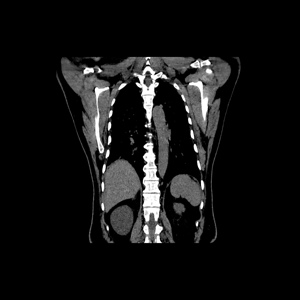

Prediction: Cyst   Confidence: 99.98%


In [56]:
def detect_kidney(img_path, model, image_size=IMAGE_SIZE):
    img = load_img(img_path, target_size=(image_size, image_size))
    arr = np.array(img).astype('float32') / 255.0
    arr = np.expand_dims(arr, axis=0)
    pred = model.predict(arr)[0]
    idx = np.argmax(pred)
    label = labels_list[idx]
    conf = pred[idx]
    display(Image.open(img_path).resize((300,300)))
    print(f"Prediction: {label}   Confidence: {conf*100:.2f}%")

Example = "C:\\Users\\Yashwardhan Shinde\\PBL Project\\Chronic_kidney_diesease_analysis\\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\\TUMOR\\Tumor- (1044).jpg"
Example1 = "C:\\Users\\Yashwardhan Shinde\\PBL Project\\Chronic_kidney_diesease_analysis\\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\\CYST\\Cyst- (2569).jpg"

detect_kidney(Example1, model)


<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\Yashwardhan Shinde\AppData\Local\Temp\ipykernel_17704\2805364970.py:1: SyntaxWarning: invalid escape sequence '\C'
  Example2 = "C:\\Users\\Yashwardhan Shinde\\PBL Project\Chronic_kidney_diesease_analysis\\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\\Normal\\Normal- (849).jpg"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


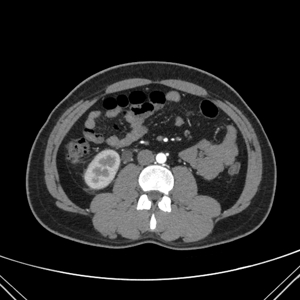

Prediction: Normal   Confidence: 99.65%


In [70]:
Example2 = "C:\\Users\\Yashwardhan Shinde\\PBL Project\Chronic_kidney_diesease_analysis\\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\\Normal\\Normal- (849).jpg"
detect_kidney(Example2, model)